# Analysis of unemployment

In [ ]:
#| label: setup
#| cache: false

rm(list = ls())
gc()

          used (Mb) gc trigger (Mb) max used (Mb)
Ncells  830071 44.4    1611192 86.1  1176572 62.9
Vcells 1647086 12.6    8388608 64.0  2726541 20.9

here() starts at C:/Users/L E N O V O/OneDrive - imssmx/Documents/IMSS/RPD

## Sample Design and Definition of the Running Variable

The data for the RD analysis is constructed from the administrative data
set of the *Instituto Mexicano del Seguro Social* (IMSS) that consists
of a matched employer-employee panel following the entirety of the
formal labor market. Although it does not contain data on unemployment
explicitly (i.e. the cause of, the start of or the duration of
unemployment), unemployment spelss can be inferred from the gaps in the
employment data. A gap can be defined as a period of time in which an
individual is not formally employed by any firm. Although this does not
necessarily mean that the individual is unemployed[1], it is sufficient
for the UI authority to consider the individual as unemployed and thus
eligible for UI benefits.

Because the administrative data covers *everything, everywhere all at
once* I narrowed the analysis sample to workers who entered the formal
labor market between January 2014 and December 2016. This assures that
workers are all subject to the same Pension Reform (as they all entered
after it came into effect in July 1997) and face the same incentives
regarding the accumulation of weeks of contribution and individual
account balance to the pension-funded UI system. Additionally, the
*Retiro Parcial por Desempleo* was widely popular after the 2008
financial crisis.

This renders an analysis universe of 5,906,121 workers that registered
145,383,926 social security movements[2].

[1] A gap could also be produced by voluntary separation, exit into
informality, or involuntary separation.

[2] A social security movement represents a particular labor relation
between employee and employer, at some wage for a period o time. At the
most granular level, social security movements are represented as rows
in the matched employee-employer panel.

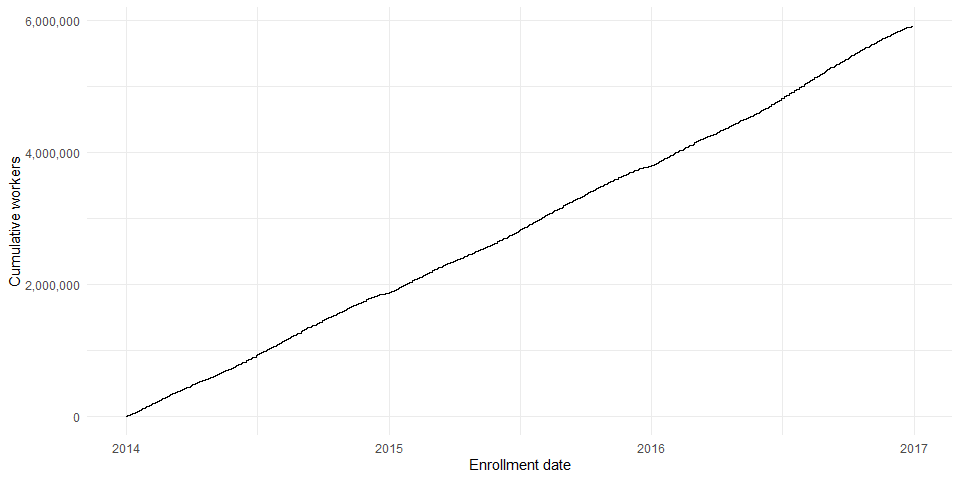

In [ ]:
#| label: fig-enrollment
#| fig-cap: "Enrollment of workers to the formal labor market from 2014 to 2016"

workers |>
  summarise(
    .by = began_working,
    n = n()
  ) |>
  collect() |>
  arrange(began_working) |>
  mutate(
    n = cumsum(n)
  ) |>
  ggplot(aes(began_working, n)) +
  geom_step() +
  labs(
    x = "Enrollment date",
    y = "Cumulative workers"
  ) +
  scale_y_continuous(labels = ~ (.x) |> scales::comma())

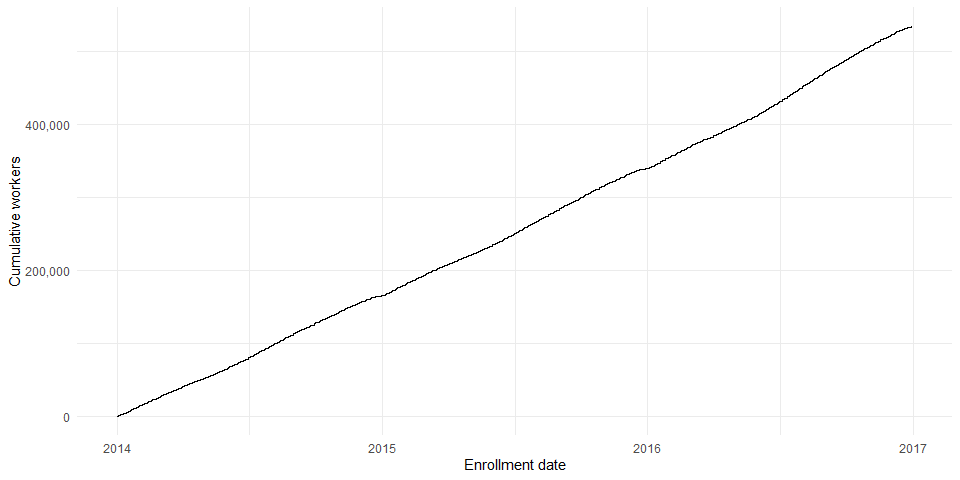

In [ ]:
#| label: fig-enrollment-final
#| fig-cap: "Enrollment of workers to the formal labor market in the final sample"

unemployment |>
  filter(interest_worker == 1) |>
  filter(contribution_days <= days_since_account_opened) |>
  filter(contribution_days < 3 * 365) |>
  filter(contribution_days > 365) |>
  summarise(
    .by = began_working,
    n = n()
  ) |>
  collect() |>
  arrange(began_working) |>
  mutate(
    n = cumsum(n)
  ) |>
  ggplot(aes(began_working, n)) +
  geom_step() +
  labs(
    x = "Enrollment date",
    y = "Cumulative workers"
  ) +
  scale_y_continuous(labels = ~ (.x) |> scales::comma())

Warning in scale_x_log10(labels = scales::comma, breaks = c(1, 5, 10, 30, :
log-10 transformation introduced infinite values.

Warning in scale_x_log10(labels = scales::comma, breaks = c(1, 5, 10, 15, :
log-10 transformation introduced infinite values.

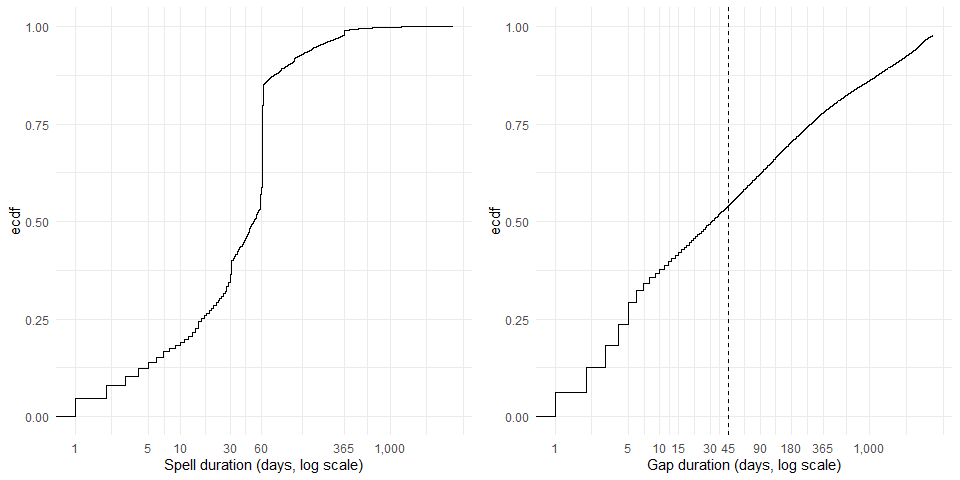

In [ ]:
#| label: fig-employment-spells
#| fig-cap: "Duration of employment spells and gaps"

ci_clean <- ci |>
  filter(partition == 1) |>
  filter(year(FEC_MOV_INI) >= 2014) |>
  filter(year(FEC_MOV_INI) <= 2024) |>
  collect() |>
  ungroup() |>
  mutate(days = as.numeric(FEC_MOV_FIN - FEC_MOV_INI) + 1) 

spells_plot <- ci_clean |>
  summarise(
    .by = days,
    n = n()
  ) |>
  collect() |>
  arrange(days) |>
  mutate(
    n = n / sum(n),
    n = cumsum(n)

  ) |>
  add_row(days = 0, n = 0) |>
  ggplot(aes(days, n)) +
  geom_step() +
  scale_x_log10(labels = scales::comma,
                breaks = c(1, 5, 10, 30, 60, 365, 1000)) +
  labs(
    x = "Spell duration (days, log scale)",
    y = "ecdf"
  )

gaps_plot <- unemployment |>
  summarise(
    .by = unemployment_days,
    n = n()
  ) |>
  collect() |>
  arrange(unemployment_days) |>
  mutate(
    n = n / sum(n),
    n = cumsum(n)
  ) |>
  add_row(unemployment_days = 0, n = 0) |>
  ggplot(aes(unemployment_days, n)) +
  geom_step() +
  scale_x_log10(labels = scales::comma,
                breaks = c(1, 5, 10, 15, 30, 45, 90, 180, 365, 1000)) +
  geom_vline(xintercept = 45, linetype = "dashed") +
  labs(
    x = "Gap duration (days, log scale)",
    y = "ecdf"
  ) 


ggarrange(spells_plot, gaps_plot, nrow = 1, ncol = 2)

ℹ Specify `as_vector = TRUE` (the current default) or `FALSE` (what it will change to) in `pull()`
ℹ Or, set `options(arrow.pull_as_vector)` globally
This warning is displayed once every 8 hours.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   2.092   3.000  77.000 

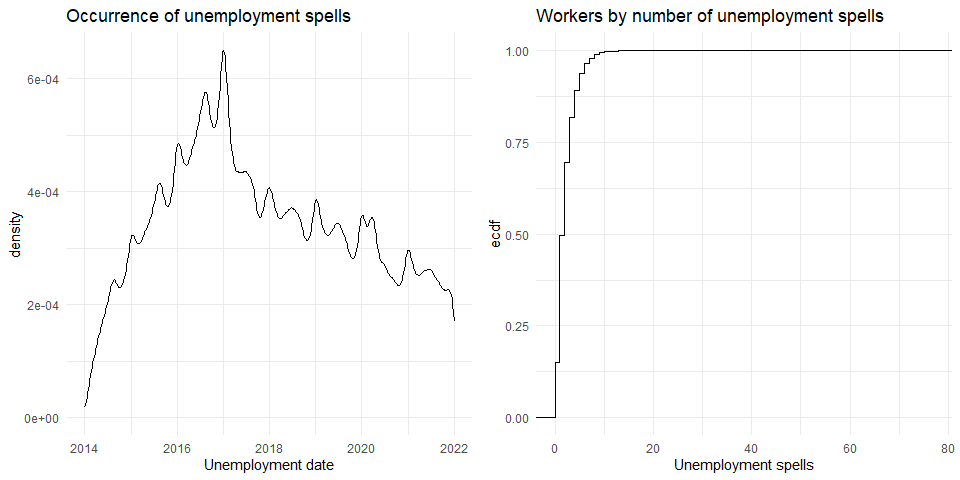

In [ ]:
#| label: fig-unemployment
#| fig-cap: "Unemployment spells > 45 days"

start_plot <- unemployment |>
  filter(meets_unemp_days_criterion == 1) |>
  select(unemployment_date) |>
  collect() |>
  ggplot(aes(unemployment_date)) +
  geom_density() +
  labs(
    title = "Occurrence of unemployment spells",
    x = "Unemployment date"
  )

In [ ]:
#| label: tbl-interest-balance
#| tbl-cap: "Features of workers included and excluded from the analysis" 

unemployment |>
  distinct(
    CVE_NSS,
    interest_worker, 
    female,
    birth_date,
    began_working
  ) |>
  select(-CVE_NSS) |>
  collect() |>
  mutate(
    across(where(is.Date), decimal_date),
    no_curp = is.na(birth_date),
    interest_worker = factor(
      interest_worker,
      levels = c(0, 1),
      labels = c("Not of interest", "Interest")
    )
  ) |>
  tbl_summary(
    by = interest_worker,
    statistic = list(all_continuous() ~ "{mean} ({sd})"),
    label = list(
      female = "Female",
      birth_date = "Birth date",
      began_working = "Date began working",
      no_curp = "No CURP"
  )
  )  |>
  as_gt() 

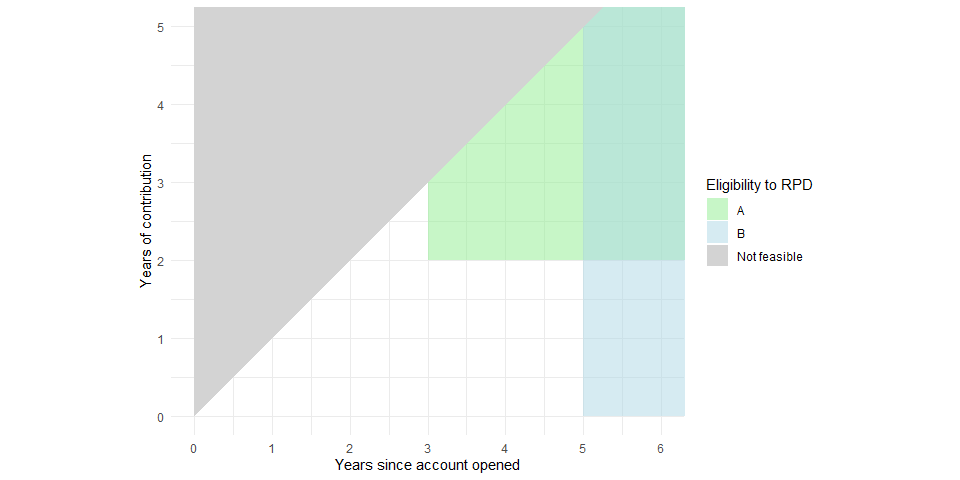

In [ ]:
#| label: fig-eligibility
#| fig-cap: "Eligibility to RPD"

ggplot() +
    geom_rect(aes(
        xmin = 3,
        xmax = 10,
        ymin = 2,
        ymax = 10,
        fill = "A"
    ), alpha = 0.5) +
    geom_rect(aes(
        xmin = 5,
        xmax = 10,
        ymin = 0,
        ymax = 10,
        fill = "B"
    ), alpha = 0.5) +
    geom_polygon(aes(
        x = c(0, 10, 0),
        y = c(0, 10, 10),
        fill = "Not feasible"
    ), alpha = 1) +
    labs(
        x = "Years since account opened",
        y = "Years of contribution",
        fill = "Eligibility to RPD"
    ) +
    scale_fill_manual(
        values = c(
            "A" = "lightgreen",
            "B" = "lightblue",
            "Dropped*" = "lightcoral",
            "Not feasible" = "lightgray"
        )
    ) +
    scale_x_continuous(
        breaks = seq(0, 8, 1)
    ) +
    coord_fixed(
        xlim = c(0, 6),
        ylim = c(0, 5)
    )

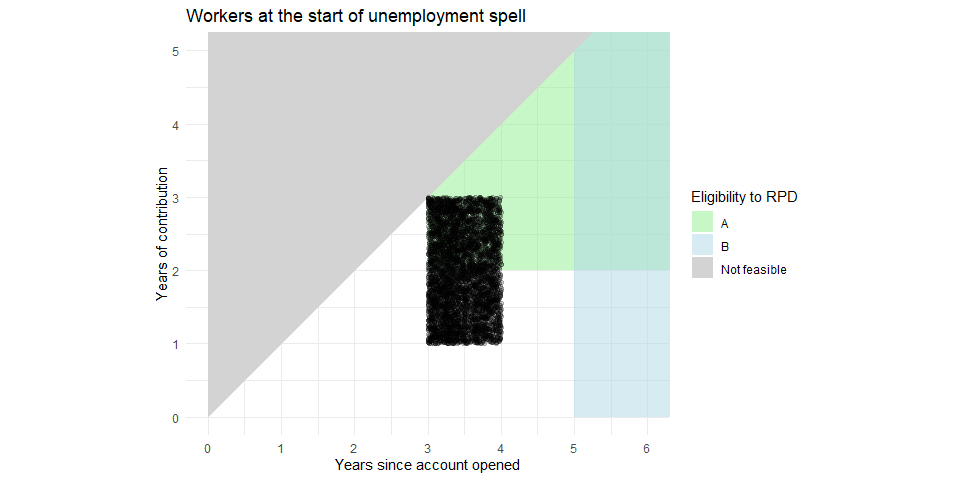

In [ ]:
#| label: fig-sample-selection
#| fig-cap: "Sample selection"

set.seed(123)

interest_events <- unemployment |>
  filter(interest_event == 1) |>
  filter(contribution_days <= days_since_account_opened) |>
  filter(contribution_days < 3 * 365) |>
  filter(contribution_days > 365) |>
  collect() |>
  sample_n(500)


ggplot() +
    geom_rect(aes(
        xmin = 3,
        xmax = 10,
        ymin = 2,
        ymax = 10,
        fill = "A"
    ), alpha = 0.5) +
    geom_rect(aes(
        xmin = 5,
        xmax = 10,
        ymin = 0,
        ymax = 10,
        fill = "B"
    ), alpha = 0.5) +
    geom_polygon(aes(
        x = c(0, 10, 0),
        y = c(0, 10, 10),
        fill = "Not feasible"
    ), alpha = 1) +

    geom_point(
        data = interest_events,
        aes(
            x = days_since_account_opened / 365,
            y = contribution_days / 365,
        ),
        alpha = 0.2
    ) +
    labs(
        title = "Workers at the start of unemployment spell",
        x = "Years since account opened",
        y = "Years of contribution",
        fill = "Eligibility to RPD"
    ) +
    scale_fill_manual(
        values = c(
            "A" = "lightgreen",
            "B" = "lightblue",
            "Dropped*" = "lightcoral",
            "Not feasible" = "lightgray"
        )
    ) +
    scale_x_continuous(
        breaks = seq(0, 8, 1)
    ) +
    coord_fixed(
        xlim = c(0, 6),
        ylim = c(0, 5)
    )

## Covid-19 and Unemployment